# Translation analysis of aggregate tracks

In [29]:
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib notebook

# Load the data file that contains the aggregate tracks
data_file = 'C:/Users/Deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/TranslationAnalysis/AggregateCentroidTracks/Sphere015_0_187.csv'

df = pd.read_csv(data_file)

list(df.columns)

['Unnamed: 0',
 'track ID',
 'track file',
 'Time',
 'sphere centroid X',
 'sphere centroid Z',
 'object bbox X',
 'object bbox Z',
 'object diameter (px)',
 'image file',
 'Xobj',
 'ZobjWheel',
 'Xobj_image',
 'Zobj_image']

<IPython.core.display.Javascript object>


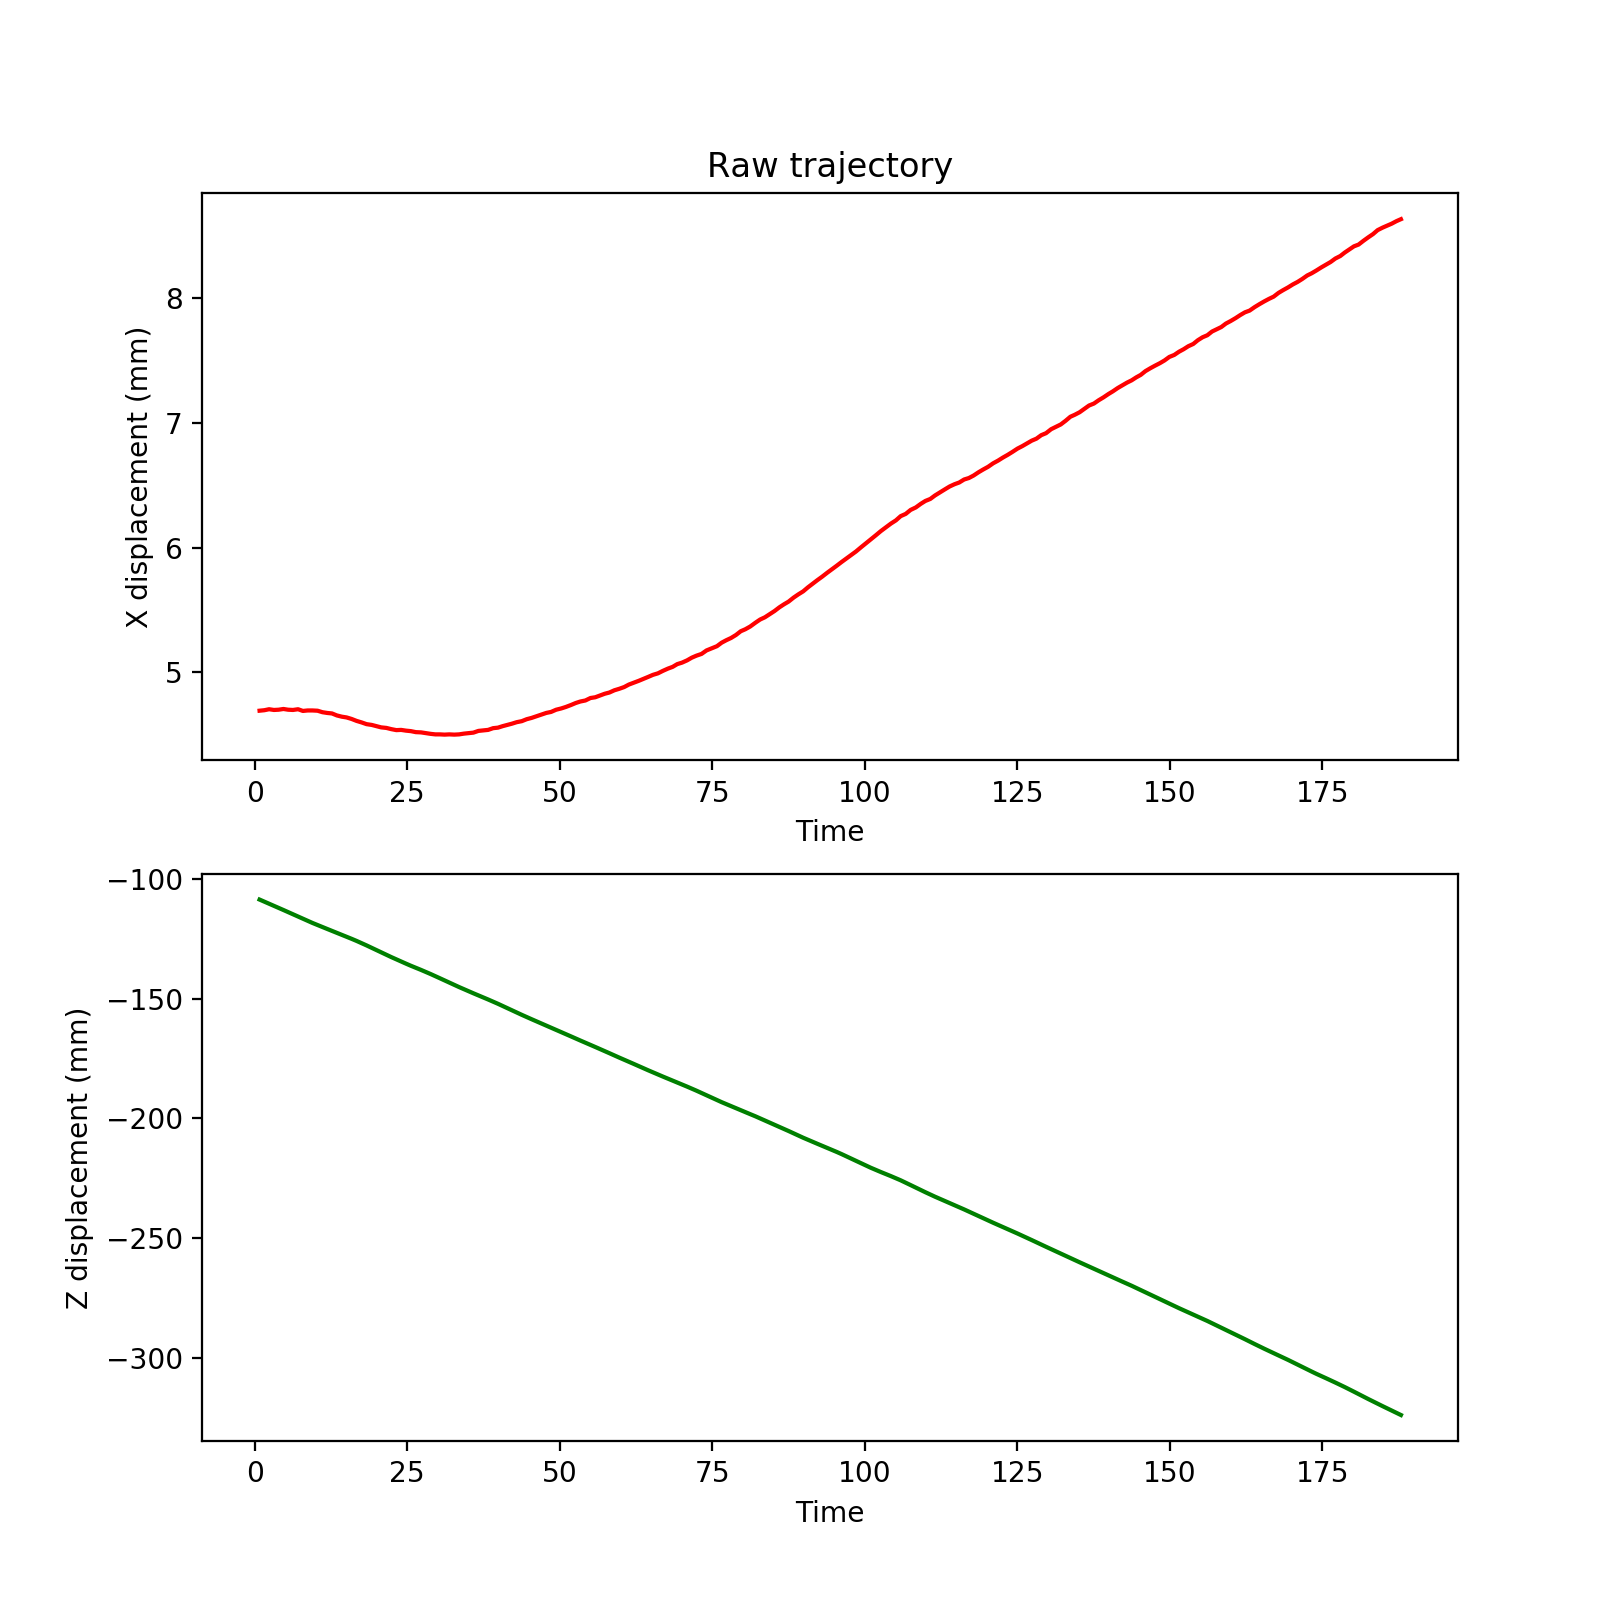

In [30]:
# Plot the original track
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1,figsize = (8,8))
ax1.set_title('Raw trajectory')
ax1.plot(df['Time'], df['Xobj'], 'r-', label = 'X displacement')
ax1.set_xlabel('Time')
ax1.set_ylabel('X displacement (mm)')

ax2.plot(df['Time'], df['ZobjWheel'], 'g-', label = 'Z displacement')
ax2.set_xlabel('Time')
ax2.set_ylabel('Z displacement (mm)')

plt.show()

In [31]:
# Subtract the image displacement contribution to the trajectory.
X_stage = df['Xobj'] - df['Xobj_image']
Z_stage = df['ZobjWheel'] - df['Zobj_image']


<IPython.core.display.Javascript object>


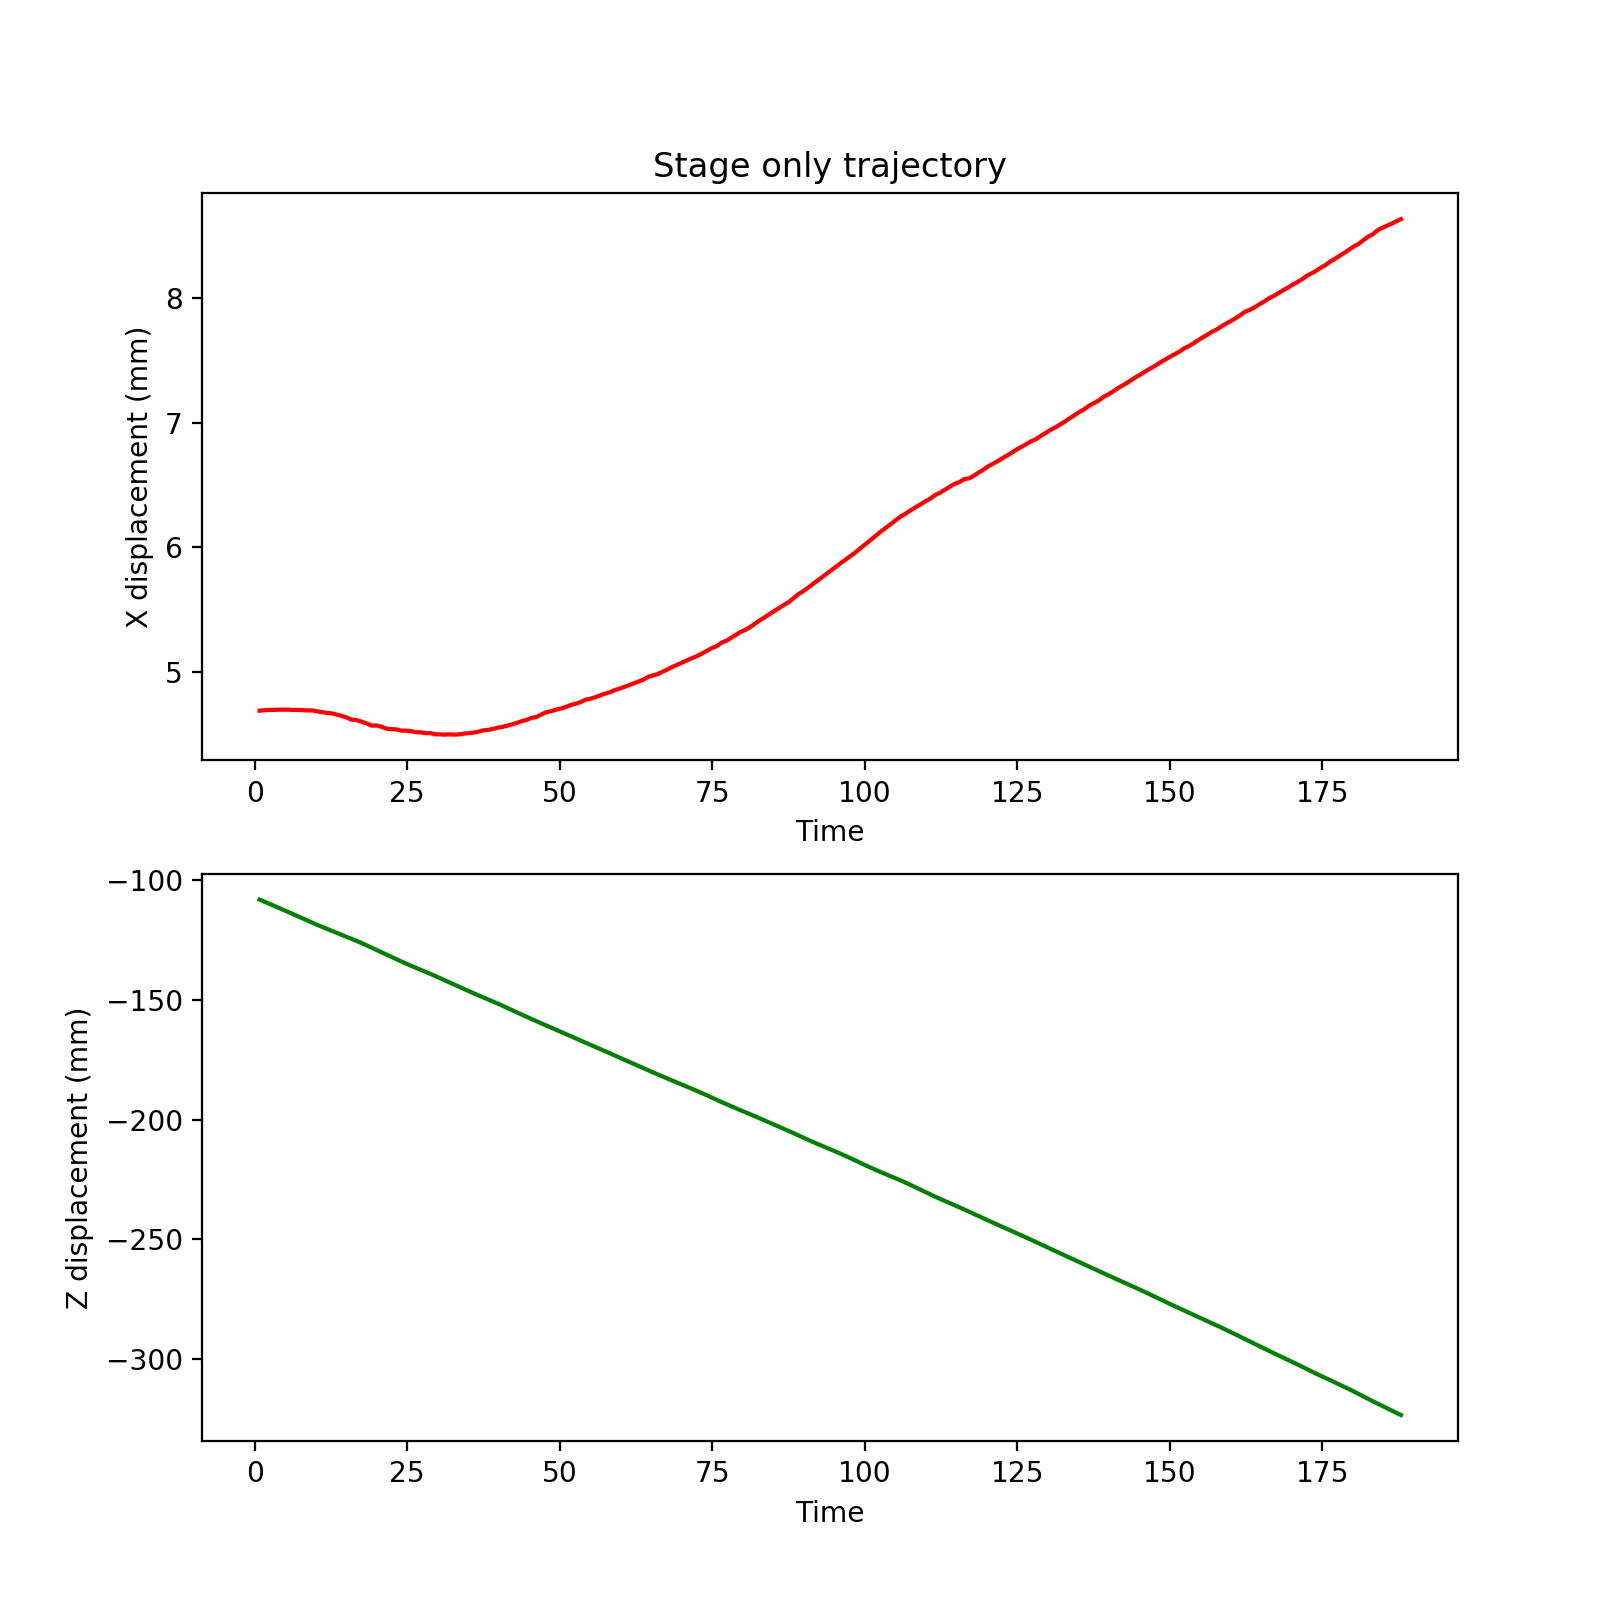

In [33]:
# Plot the trajectory of stage alone.
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1,figsize = (8,8))
ax1.set_title('Stage only trajectory')
ax1.plot(df['Time'], X_stage, 'r-', label = 'X displacement')
ax1.set_xlabel('Time')
ax1.set_ylabel('X displacement (mm)')

ax2.plot(df['Time'], Z_stage, 'g-', label = 'Z displacement')
ax2.set_xlabel('Time')
ax2.set_ylabel('Z displacement (mm)')

plt.show()

In [34]:
# Add back the true centroid displacement of the object
pixelpermm = 449 # 4x objective

X_obj_true = X_stage + df['sphere centroid X']/pixelpermm
Z_obj_true = Z_stage + df['sphere centroid Z']/pixelpermm



<IPython.core.display.Javascript object>


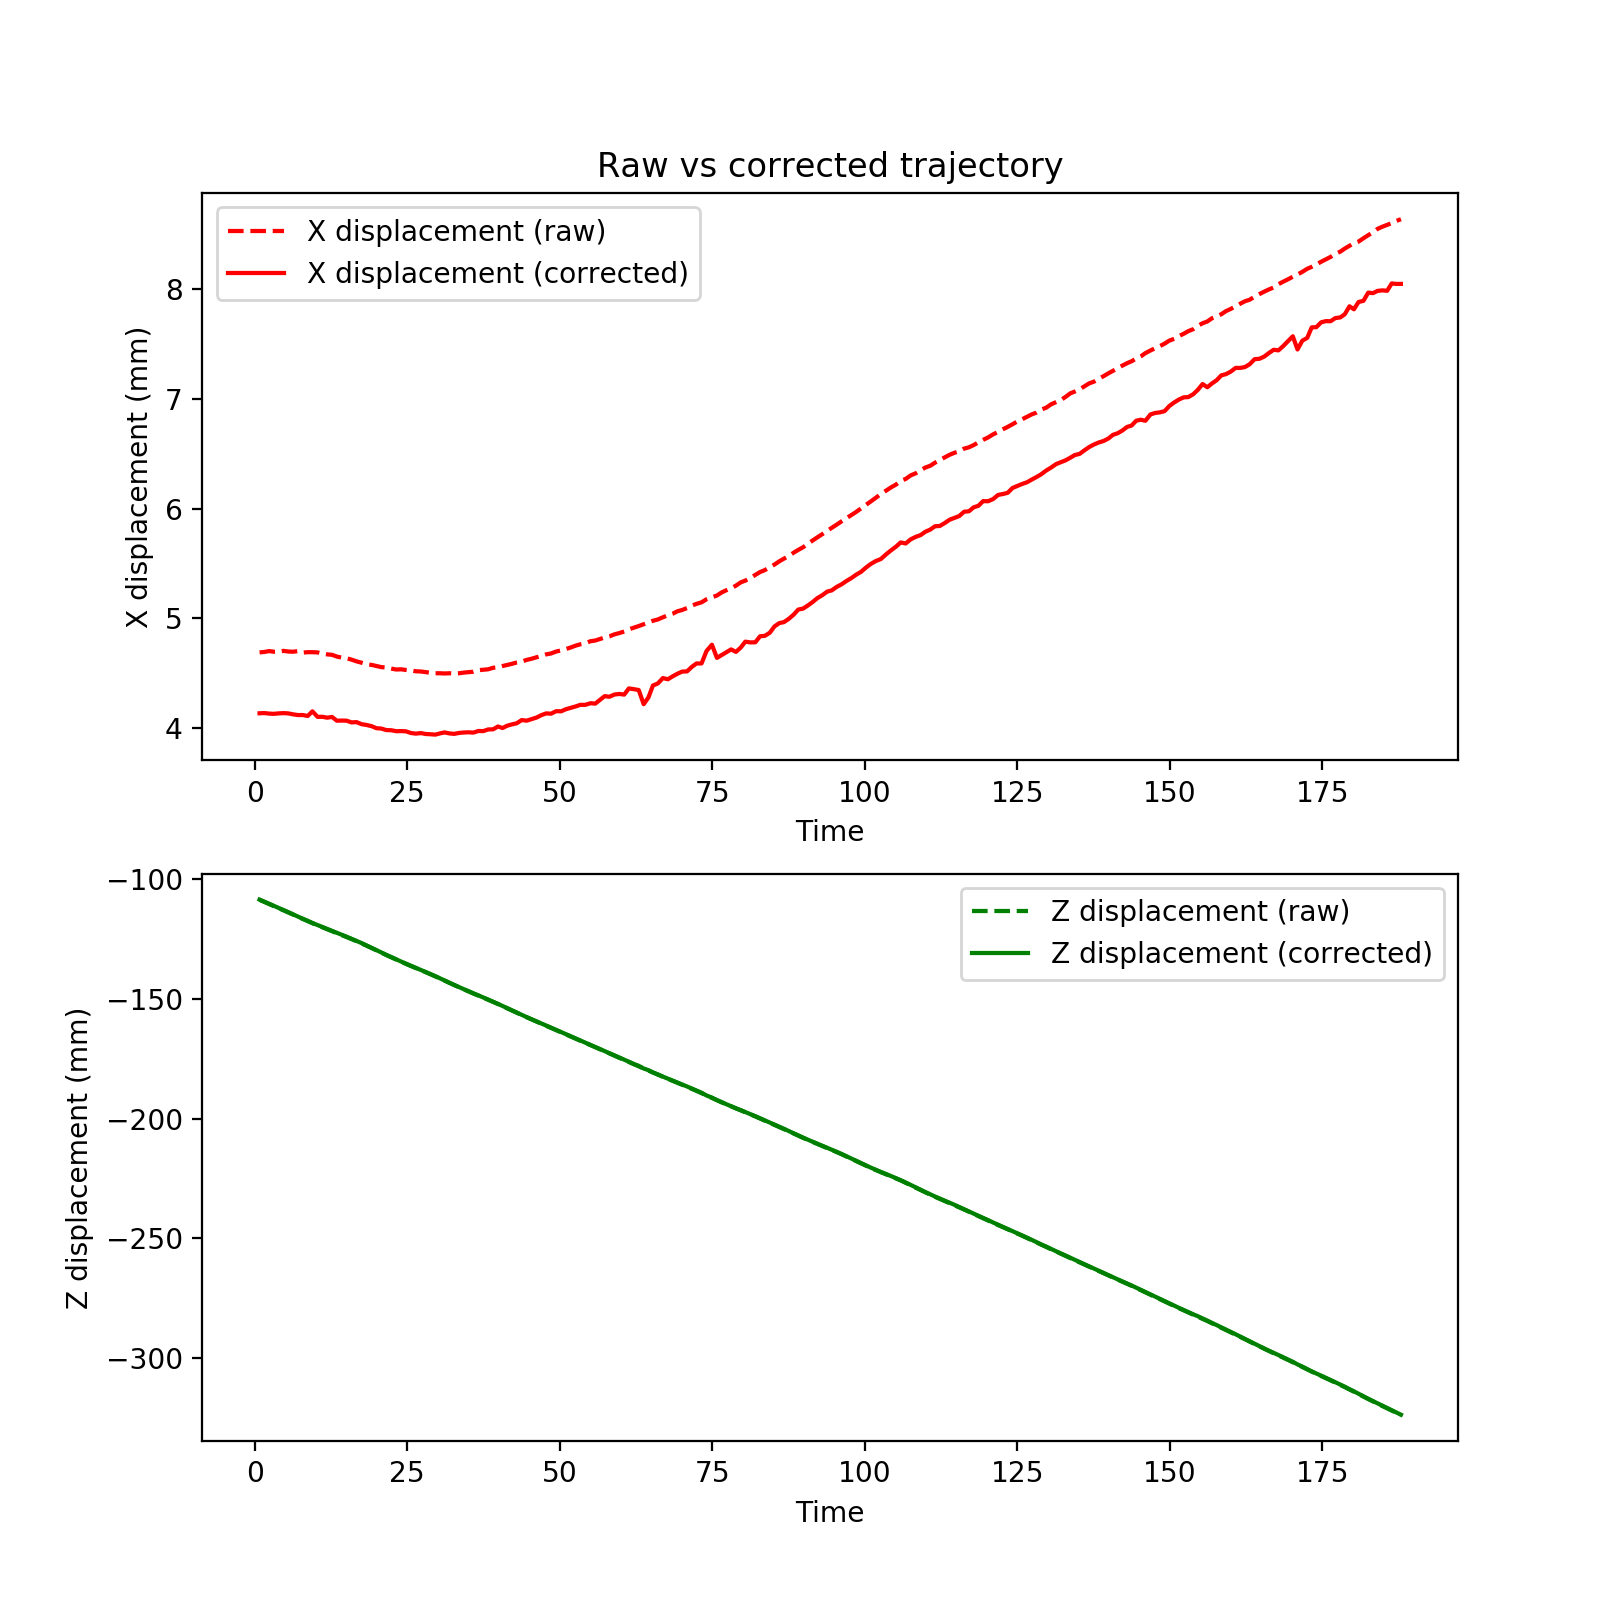

In [35]:
# Plot and compare the older and corrected trajectories
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1,figsize = (8,8))
ax1.set_title('Raw vs corrected trajectory')
ax1.plot(df['Time'], df['Xobj'], 'r--', label = 'X displacement (raw)')
ax1.plot(df['Time'], X_obj_true, 'r-', label = 'X displacement (corrected)')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('X displacement (mm)')

ax2.plot(df['Time'], df['ZobjWheel'], 'g--', label = 'Z displacement (raw)')
ax2.plot(df['Time'], Z_obj_true, 'g-', label = 'Z displacement (corrected)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Z displacement (mm)')
ax2.legend()
plt.show()

In [36]:
# Add this corrected data to the dataFrame and save it in a new location
df['Xobj_true'] = X_obj_true
df['Zobj_true'] = Z_obj_true

In [37]:
# Take moving average of the centrod trajectory to remove pixel-noise due to tracking
# Choose a window-size based on a time-interval 
time_window = 5 # Time window over which we calculate the velocity in seconds

time_vect = np.array(df['Time'])

delta_t_avg = np.nanmean(time_vect[1:] - time_vect[:-1])

print('Mean time interval: {} s'.format(delta_t_avg))

window_size = int(time_window/delta_t_avg)

# make the window-size an even integer
if window_size%2 !=0:
    window_size+=1

df['Xobj_true'] = np.array(df.loc[:,'Xobj_true'].rolling(window = window_size, center = True).mean())
df['Zobj_true'] = np.array(df.loc[:,'Zobj_true'].rolling(window = window_size, center = True).mean())


Mean time interval: 0.7892827004219409 s


<IPython.core.display.Javascript object>


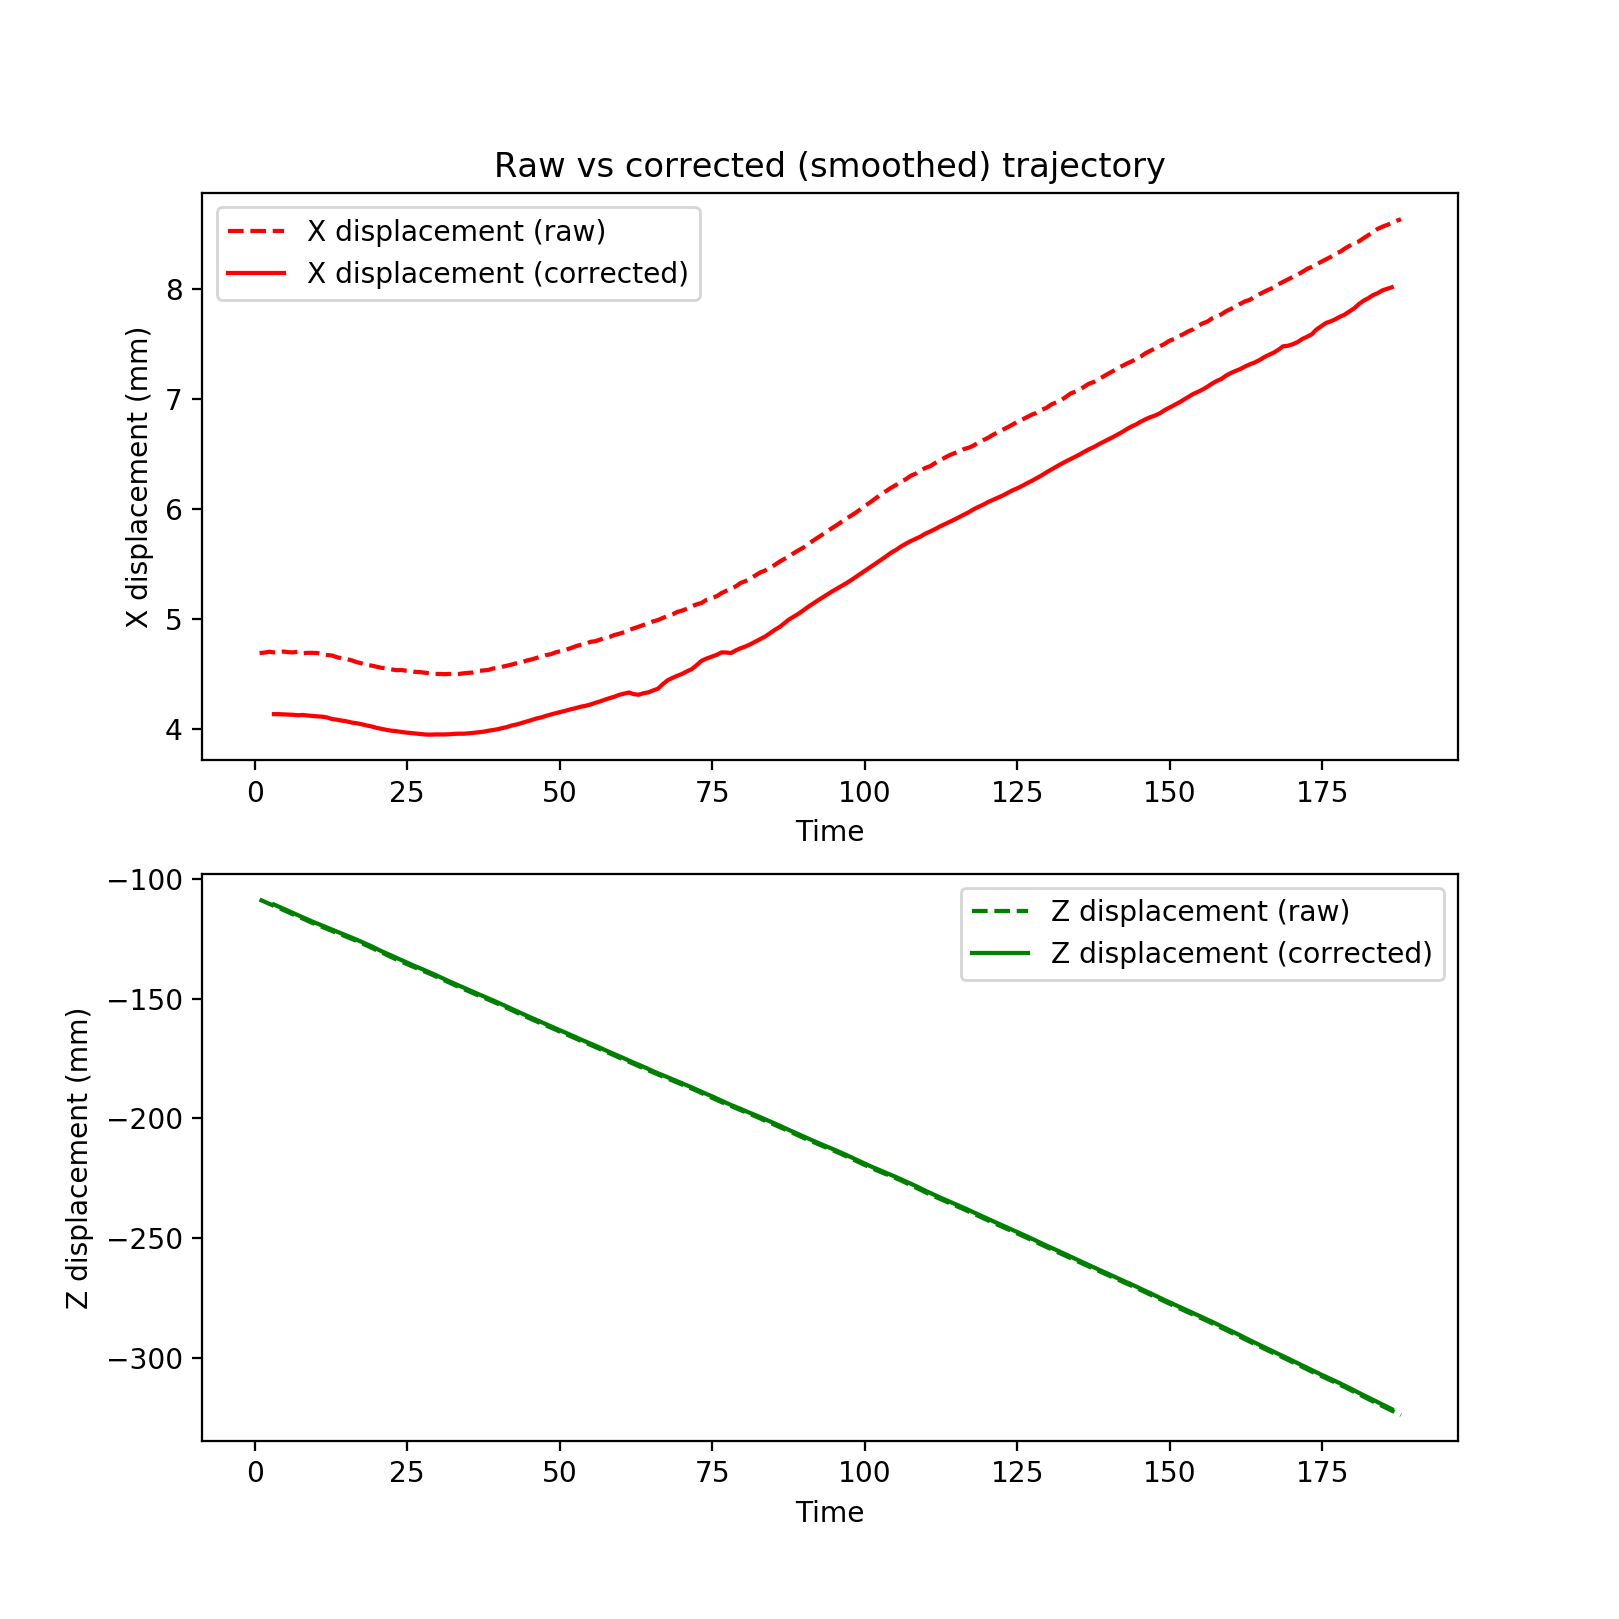

In [38]:
# Plot the final corrected trajectory
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1,figsize = (8,8))
ax1.set_title('Raw vs corrected (smoothed) trajectory')
ax1.plot(df['Time'], df['Xobj'], 'r--', label = 'X displacement (raw)')
ax1.plot(df['Time'], df['Xobj_true'], 'r-', label = 'X displacement (corrected)')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('X displacement (mm)')

ax2.plot(df['Time'], df['ZobjWheel'], 'g--', label = 'Z displacement (raw)')
ax2.plot(df['Time'], df['Zobj_true'], 'g-', label = 'Z displacement (corrected)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Z displacement (mm)')
ax2.legend()
plt.show()

In [ ]:
# Save a plot of the final corrected trajectory


In [47]:
# Calculate velocity statistics
def velocity_central_diff(time, data):
        
    assert(len(time) == len(data))
    
    data_len = len(time)
    velocity = np.zeros(data_len)
    
    for i in range(data_len):
        if(i==0):
            # Forward difference at the start points
            velocity[i] = (data[i+1] - data[i])/(time[i+1] - time[i])
        
        elif(i== data_len-1):
            # Backward difference at the end points
            velocity[i] = (data[i] - data[i-1])/(time[i] - time[i-1])
    
        else:
            # Central difference for all other points
            velocity[i] = (data[i+1] - data[i-1])/(time[i+1] - time[i-1])
            
    return velocity

Time = np.array(df['Time'])
Xobj_true = np.array(df['Xobj_true'])
Zobj_true = np.array(df['Zobj_true'])

print(len(Xobj_true[:-1]))

velocity_X = velocity_central_diff(Time, Xobj_true)
velocity_Z = velocity_central_diff(Time, Zobj_true)

df['Velocity X'] = velocity_X
df['Velocity Z'] = velocity_Z

237


<IPython.core.display.Javascript object>


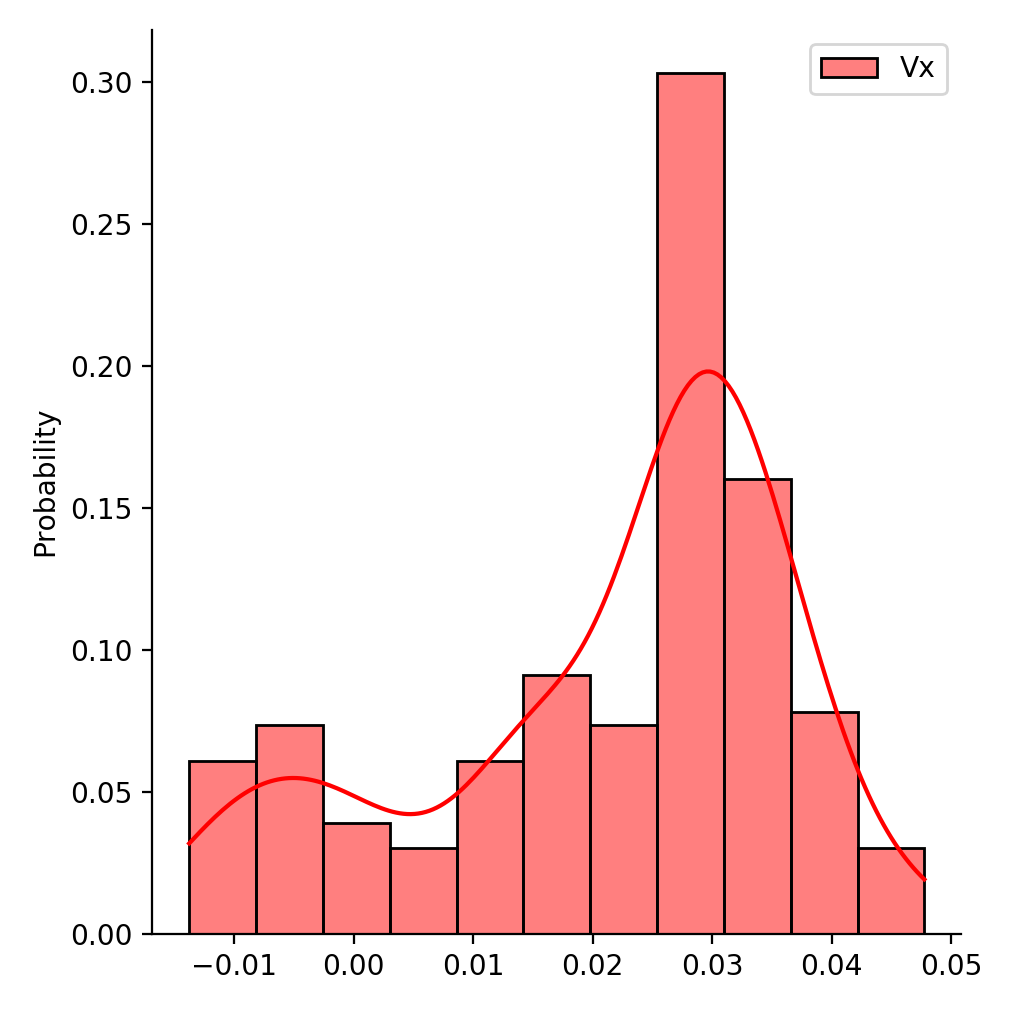

<IPython.core.display.Javascript object>


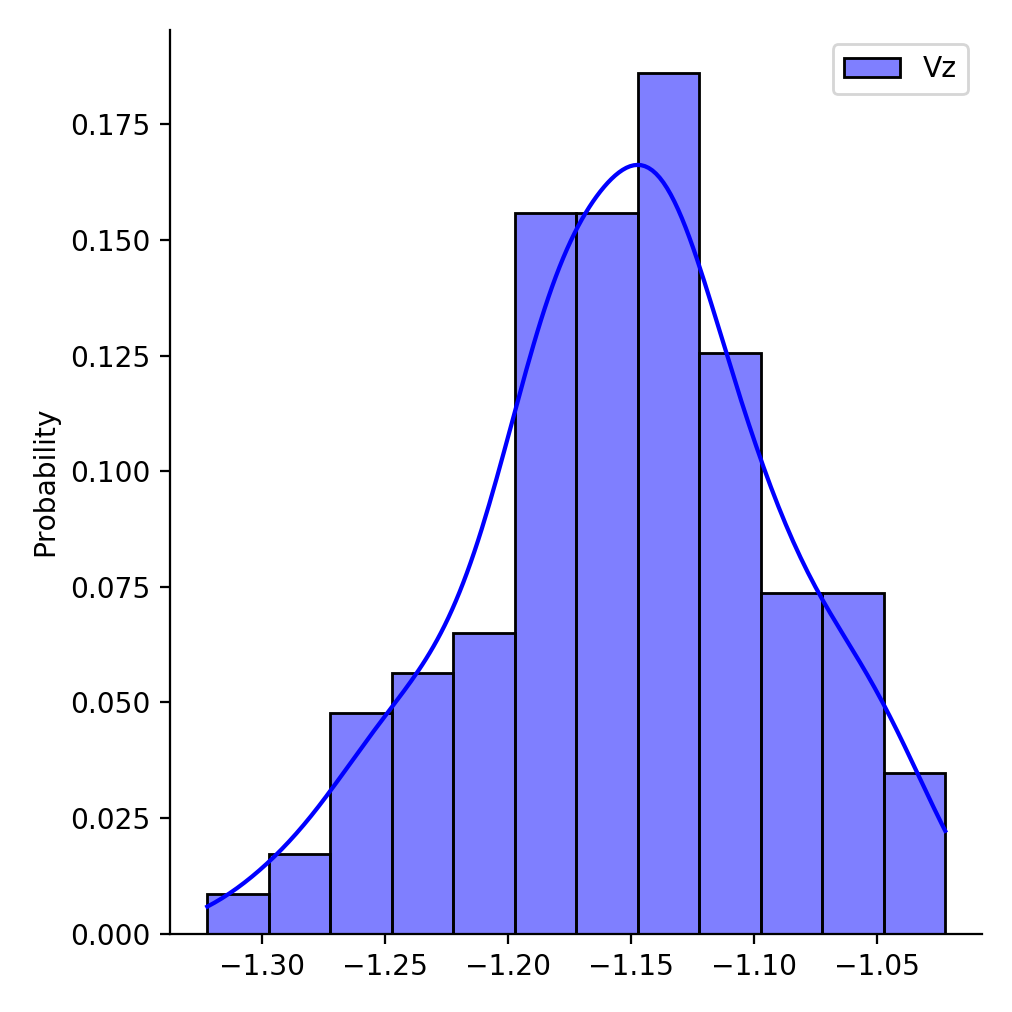

In [48]:
# Plot the velocity distribution
import seaborn as sns
sns.displot(x = velocity_X, common_norm=False, color = 'r', stat="probability", kde=True, palette="viridis", label = 'Vx')
plt.legend()
plt.show()
sns.displot(x = velocity_Z, common_norm=False, color = 'b', stat="probability", kde=True, palette="viridis", label = 'Vz')
plt.legend()
plt.show()